In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy

import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_lg
lg = spacy.load("en_core_web_lg")

2023-08-29 21:50:44.812524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Имена героев

In [4]:
characters = pd.read_csv('/content/drive/MyDrive/DS projects/Touhou/characters.csv')
characters.head(10)

,name,url
0,Alice Margatroid,/wiki/Alice_Margatroid
1,Aunn Komano,/wiki/Aunn_Komano
2,Aya Shameimaru,/wiki/Aya_Shameimaru
3,Benben Tsukumo,/wiki/Benben_Tsukumo
4,Biten Son,/wiki/Biten_Son
5,Byakuren Hijiri,/wiki/Byakuren_Hijiri
6,Category:Character Images,/wiki/Category:Character_Images
7,Character List,/wiki/Character_List
8,Chen,/wiki/Chen
9,Chimata Tenkyuu,/wiki/Chimata_Tenkyuu


In [5]:
characters.isna().sum()

name    4
url     4
dtype: int64

In [6]:
characters = characters.dropna()
characters.isna().sum()

name    0
url     0
dtype: int64

In [7]:
characters['first_name'] = characters['name'].apply(lambda x: x.split(' ')[0])
characters.head(10)

<ipython-input-7-0b6a3274a6dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters['first_name'] = characters['name'].apply(lambda x: x.split(' ')[0])


,name,url,first_name
0,Alice Margatroid,/wiki/Alice_Margatroid,Alice
1,Aunn Komano,/wiki/Aunn_Komano,Aunn
2,Aya Shameimaru,/wiki/Aya_Shameimaru,Aya
3,Benben Tsukumo,/wiki/Benben_Tsukumo,Benben
4,Biten Son,/wiki/Biten_Son,Biten
5,Byakuren Hijiri,/wiki/Byakuren_Hijiri,Byakuren
6,Category:Character Images,/wiki/Category:Character_Images,Category:Character
7,Character List,/wiki/Character_List,Character
8,Chen,/wiki/Chen,Chen
9,Chimata Tenkyuu,/wiki/Chimata_Tenkyuu,Chimata


## Разметка текста, выделение сущностей

In [8]:
path = '/content/drive/MyDrive/DS projects/Touhou/descriptions.txt'
book_text = open(path).read()
book_doc = lg(book_text)
displacy.render(book_doc[:500], style='ent', jupyter=True)

Для каждого предложения формируется список встретившихся в нем сущностей

In [9]:
def create_entities(book_doc):
  entity_data = []

  for sentence in book_doc.sents:
    # creating a list of enteties for each sentence
    entity_list = [entity.text for entity in sentence.ents]
    entity_data.append({'sentence' : sentence, 'entity' : entity_list})

  return entity_data

In [10]:
entity_data = pd.DataFrame(create_entities(book_doc))
entity_data.head(10)

,sentence,entity
0,"(As, we, first, get, a, glimpse, of, Gensokyo,...","[first, Gensokyo, Hakurei, the Shrine Maiden]"
1,"(The, Shrine, is, located, near, the, gate, to...","[Makai, the Demon World]"
2,"(Exiting, the, Shrine, ,, Reimu, is, tested, b...",[Shingyoku]
3,"(If, the, chosen, path, is, Makai, ,, our, her...",[Makai]
4,(eyes-),[]
5,"(YuugenMagan, .)",[YuugenMagan]
6,"(She, then, is, encountered, by, the, not, -, ...",[Elis]
7,"(At, the, edge, of, Makai, ,, Reimu, enters, t...","[Makai, the Fallen Shrine, Sariel]"
8,"(Sariel, may, have, led, Reimu, into, the, Fal...","[Sariel, Makai]"
9,"(Reimu, defeats, Sariel, and, escapes, Makai, ...","[Sariel, Makai]"


Оставляем в столбце сущностей только имена


In [11]:
def filtering(entity, character_df):
  res = []

  for elem in entity:
    if elem in character_df['name'].unique() or elem in character_df['first_name'].unique():
      res.append(elem)

  return res

In [12]:
entity_data['character_entity'] = entity_data['entity'].apply(lambda x: filtering(x, characters))
entity_data = entity_data[entity_data['character_entity'].map(lambda d: len(d)) > 0]
entity_data.head(10)

,sentence,entity,character_entity
5,"(YuugenMagan, .)",[YuugenMagan],[YuugenMagan]
6,"(She, then, is, encountered, by, the, not, -, ...",[Elis],[Elis]
7,"(At, the, edge, of, Makai, ,, Reimu, enters, t...","[Makai, the Fallen Shrine, Sariel]",[Sariel]
8,"(Sariel, may, have, led, Reimu, into, the, Fal...","[Sariel, Makai]",[Sariel]
9,"(Reimu, defeats, Sariel, and, escapes, Makai, ...","[Sariel, Makai]",[Sariel]
10,"(If, the, chosen, path, is, Jigoku, ,, our, he...","[Jigoku, Mima, first]",[Mima]
12,"(After, defeating, her, ,, she, comes, across,...",[Kikuri],[Kikuri]
13,"(Finally, ,, deep, within, Hell, ,, Reimu, ent...",[Konngara],[Konngara]
14,"(The, heroine, defeats, Konngara, and, leaves,...","[Konngara, Jigoku]",[Konngara]
15,"(Determined, to, find, who, sent, these, monst...",[Genjii],[Genjii]


In [13]:
def get_first_name(names):
  return [x.split(' ')[0] for x in names]

In [14]:
entity_data['character_entity'] = entity_data['character_entity'].apply(get_first_name)
entity_data.head(10)

,sentence,entity,character_entity
5,"(YuugenMagan, .)",[YuugenMagan],[YuugenMagan]
6,"(She, then, is, encountered, by, the, not, -, ...",[Elis],[Elis]
7,"(At, the, edge, of, Makai, ,, Reimu, enters, t...","[Makai, the Fallen Shrine, Sariel]",[Sariel]
8,"(Sariel, may, have, led, Reimu, into, the, Fal...","[Sariel, Makai]",[Sariel]
9,"(Reimu, defeats, Sariel, and, escapes, Makai, ...","[Sariel, Makai]",[Sariel]
10,"(If, the, chosen, path, is, Jigoku, ,, our, he...","[Jigoku, Mima, first]",[Mima]
12,"(After, defeating, her, ,, she, comes, across,...",[Kikuri],[Kikuri]
13,"(Finally, ,, deep, within, Hell, ,, Reimu, ent...",[Konngara],[Konngara]
14,"(The, heroine, defeats, Konngara, and, leaves,...","[Konngara, Jigoku]",[Konngara]
15,"(Determined, to, find, who, sent, these, monst...",[Genjii],[Genjii]


## Построение взаимосвязей

Последовательно смотрим каждые window_size предложений и почередно собираем в пары все имена, которые встретились в этих пр-иях.

Например, если встретились имена Marisa, Eirin, Alice, то будут сформированы пары Marisa-Eirin и Eirin-Alice

In [15]:
from itertools import groupby

def create_relationships(df, window_size=3):
  last_idx = df.index[-1]
  relationships = []

  for i in range(last_idx):
    stop_idx = min(last_idx, i + window_size) # минимум из макс индекса датафрейма и строки+размер окна, чтобы не выйти за пределы
    tmp = sum((df.loc[i : stop_idx].character_entity), [])

    characters_in_sentences = [i[0] for i in groupby(tmp)] # удаляем подряд идущие дубликаты: [A, A, B] -> [A, B]

    if len(characters_in_sentences) > 1:
      for pos, elem in enumerate(characters_in_sentences[:-1]):
        relationships.append({'first' : elem, 'second' : characters_in_sentences[pos + 1]})

  return relationships

In [16]:
my_relationships = create_relationships(entity_data)
my_relationships = pd.DataFrame(my_relationships)
my_relationships = pd.DataFrame(np.sort(my_relationships.values, axis = 1), columns = my_relationships.columns)
my_relationships.head(10)

,first,second
0,Elis,YuugenMagan
1,Elis,YuugenMagan
2,Elis,Sariel
3,Elis,YuugenMagan
4,Elis,Sariel
5,Elis,Sariel
6,Mima,Sariel
7,Mima,Sariel
8,Mima,Sariel
9,Kikuri,Mima


Каждой паре имен присваиваем число, равное количеству упоминаний этой пары в датафрейме.

In [17]:
my_relationships['weight'] = 1
my_relationships = my_relationships.groupby(['first','second'], sort=False, as_index=False).sum()
my_relationships.head(10)

,first,second,weight
0,Elis,YuugenMagan,3
1,Elis,Sariel,3
2,Mima,Sariel,3
3,Kikuri,Mima,2
4,Kikuri,Konngara,3
5,Genjii,Konngara,3
6,Genjii,Rika,6
7,Genjii,Meira,3
8,Marisa,Meira,3
9,Marisa,Mima,14


## Визуализация результатов

In [18]:
import networkx as nx

G = nx.from_pandas_edgelist(my_relationships,
                            source = 'first',
                            target = 'second',
                            edge_attr = 'weight',
                            create_using = nx.Graph())

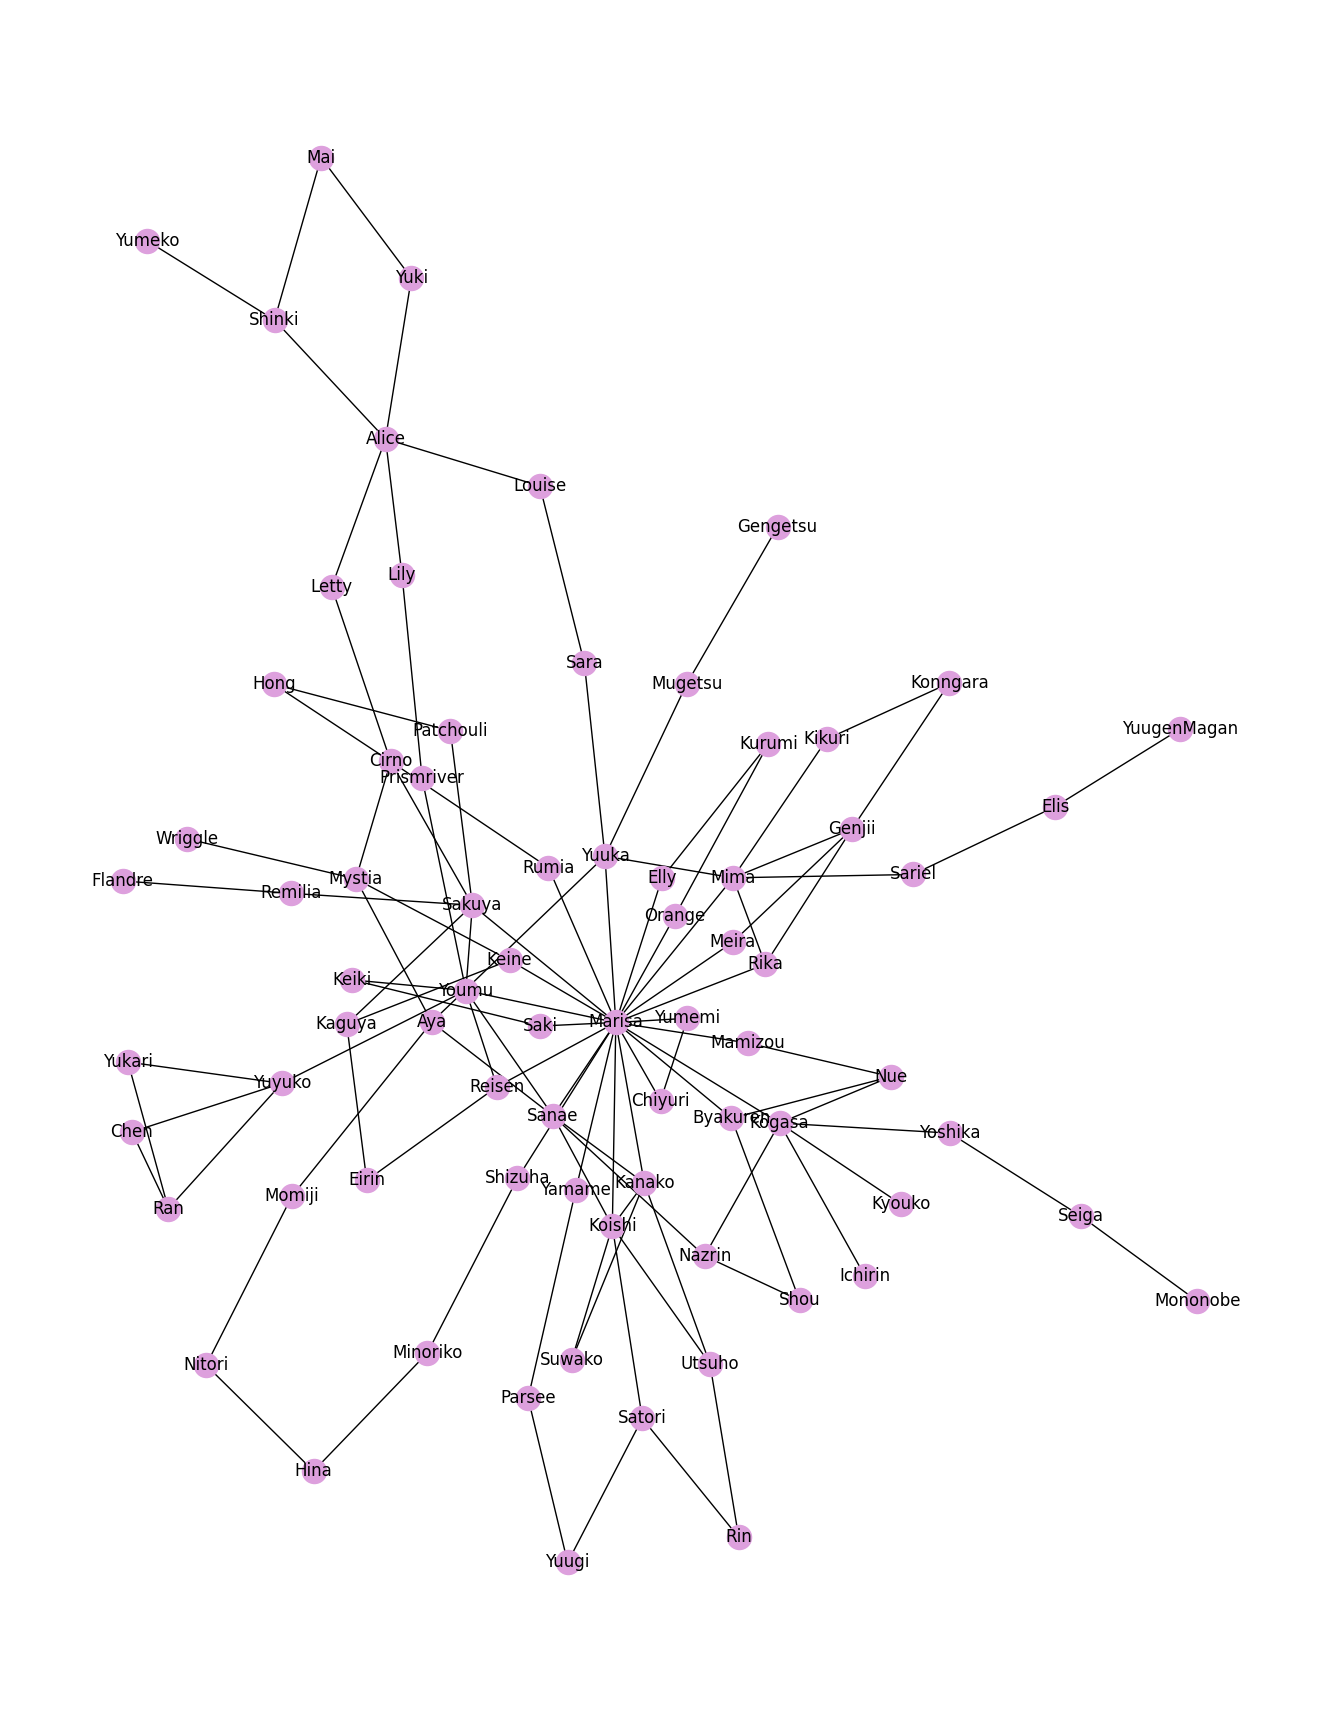

In [36]:
plt.figure(figsize=(13,17))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='plum', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
!pip install pyvis

In [21]:
from pyvis.network import Network
from IPython.core.display import display, HTML

net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('touhou.html')
display(HTML('touhou.html'))


touhou.html


Центральность - вершина с наибольшим количеством ребер (т.е. центральная)

In [22]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_dict.items(), columns=['name', 'centrality'])
degree_df.head(10)

,name,centrality
0,Elis,0.027027
1,YuugenMagan,0.013514
2,Sariel,0.027027
3,Mima,0.081081
4,Kikuri,0.027027
5,Konngara,0.027027
6,Genjii,0.054054
7,Rika,0.040541
8,Meira,0.027027
9,Marisa,0.297297


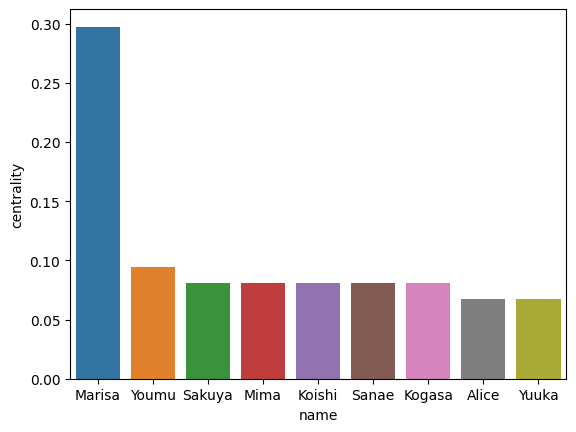

In [23]:
import seaborn as sns

sns.barplot(data=degree_df.sort_values('centrality', ascending=False)[0:9], x='name', y='centrality');

Центральность по посредничеству для каждой вершины — это количество кратчайших путей, проходящих через вершину.

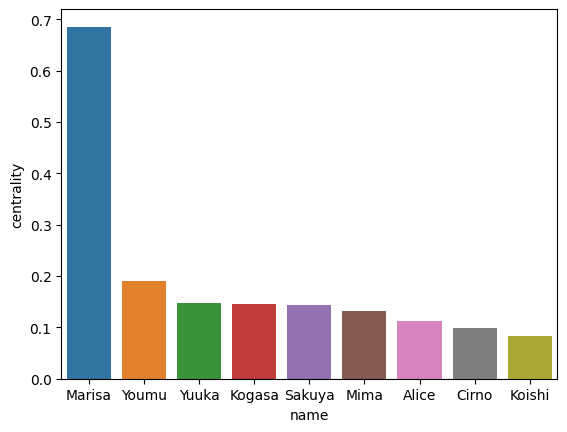

In [24]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(betweenness_dict.items(), columns=['name', 'centrality'])
sns.barplot(data=betweenness_df.sort_values('centrality', ascending=False)[0:9], x='name', y='centrality');

Близость узла - сумма длин кратчайших путей между узлом и всеми остальными узлами в графе. Используется для наождения вершин, которые могут быстро взаимодействовать с другими.

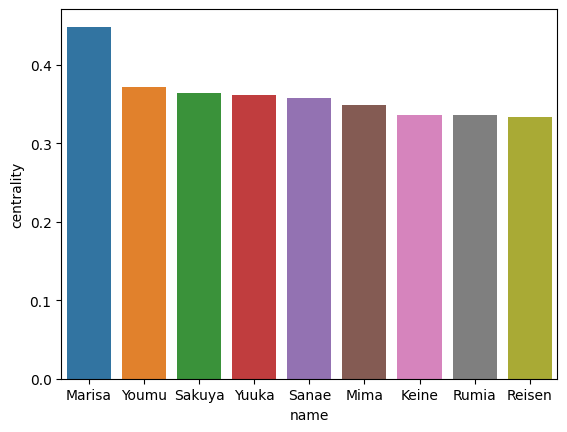

In [25]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['name', 'centrality'])
sns.barplot(data=closeness_df.sort_values('centrality', ascending=False)[0:9], x='name', y='centrality');

In [26]:
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Обнаружение групп в графе

In [27]:
from community import community_louvain
communities = community_louvain.best_partition(G)

In [28]:
pd.DataFrame(communities.items(), columns=['name', 'group']).groupby('group').count().reset_index()

,group,name
0,0,9
1,1,10
2,2,5
3,3,8
4,4,7
5,5,7
6,6,11
7,7,10
8,8,8


In [29]:
nx.set_node_attributes(G, communities, 'group')

com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
com_net.from_nx(G)

com_net.show('touhou_communities.html')
display(HTML('touhou_communities.html'))

touhou_communities.html


## Предсказание связей

In [30]:
possible_connections = [elem for elem in list(nx.jaccard_coefficient(G)) if elem[2] > 0.35]
possible_connections = pd.DataFrame(possible_connections, columns=['first_character', 'second_character', 'probability'])
possible_connections['weight'] = possible_connections['probability'] * 10
possible_connections

,first_character,second_character,probability,weight
0,Chen,Yukari,1.000000,10.000000
1,Orange,Elly,1.000000,10.000000
2,Kikuri,Genjii,0.500000,5.000000
3,YuugenMagan,Sariel,0.500000,5.000000
4,Shinki,Yuki,0.666667,6.666667
5,Alice,Mai,0.400000,4.000000
6,Yumeko,Mai,0.500000,5.000000
7,Patchouli,Cirno,0.400000,4.000000
8,Suwako,Utsuho,0.666667,6.666667
9,Satori,Utsuho,0.500000,5.000000


In [31]:
G_possible = nx.from_pandas_edgelist(possible_connections,
                            source = 'first_character',
                            target = 'second_character',
                            edge_attr = 'weight',
                            create_using = nx.Graph())



In [32]:
net2 = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')

net2.from_nx(G_possible)

net2.show('2.html')
display(HTML('2.html'))

2.html
